# Timings Inference examples 

Typical import 

In [1]:
using RoutingNetworks, TimingsInference, JLD

# Network timings optimization
## Synthesizing network data
First, we create a synthetic network `n` (with tools from RoutingNetworks.jl). We associate it with a set of synthetic "true" timings `trueTimings`. Timings contains link times and times for each path.

Uncomment visualizations to see results

In [2]:
n = urbanNetwork(8)
# visualize(n)

# random speeds (btw 0 and 130kph)
trueTimings = randomTimings(n)

# another possibility: constant predefined speed for each road-type
trueTimings = roadTypeTimings(n)

# visualize(ShowTimes(n,trueTimings))

with path and time for all 36672 possible trips


Then, we create a synthetic set of trips based on this "true" times. This is stored as a `NetworkData` object, which contained all information for timings inference: network structure, trips and speed limits

In [3]:
# All possible trips are given (for testing purposes)
pb = perfectVirtualData(trueTimings, 0.) 

# Generate data that tries to mimic real rides in a uniform city. 
pb = noisyVirtualData(trueTimings, 0.2, 2., timeStd = 20.)

Network routing times


NetworkData: trip information in network
7129 trips (19.44% density)

## Iterative methods
The `IterativeState` object represents the state of an iterative time-estimation algorithm. It contains all the data, the current computed times, the set of paths that is used...

- `LimitedPath` is an implementation, that computes iteratively a set of paths for a subset of the trip data. A limit on the number of paths can be set.

The different methods available to compute new times are:
- `lp`: minimize MAPE (Mean absolute percentage error), uses Gurobi. `lpCo` and `lpCoNbhd` (Nbhd == Neighborhood) just add continuity constraints.
- `socp`: minimize MRE (Max ratio error), uses Mosek. `socpCo` and `Nbhd` (Nbhd == Neighborhood) just add continuity constraints.
- `mip`: implements the "minimum" constraints

In [6]:
# first, initialize the iterative method with a set of times.
# Several options here
initialTimes = uniformTimes(n,50) #speed 50kph
initialTimes = pb.minTimes # maximal allowed speed
initialTimes = randomTimes(n);

# them, create the state
s = LimitedPaths(pb, initialTimes, pathsPerTrip = 3, maxTrip=1000)

# do a number of iterations of a desired algorithm
for i = 1:5
    doIteration!(s, method="lp", OutputFlag=0)
    println("Iteration $i, pathDiff=$(s.pathDiff)")
end
# solver args can also be given
# pathDiff measures how much the last iteration changed the path 
# (measure of convergence)

Iteration 1, pathDiff=8.0165
Iteration 2, pathDiff=3.102
Iteration 3, pathDiff=1.679
Iteration 4, pathDiff=1.195
Iteration 5, pathDiff=0.7925


## Stats and visualization
To understand the evolution of iterative methods, we feed the results of each iteration to a NetworkStats object. We then use this object to query and visualize the data.

- First, we modify the loop to collect the information

In [4]:
stats = VirtNetworkStats[] # this type of statistics requires that we have access to "true" times.

initialTimes = randomTimes(n);
s = LimitedPaths(pb, initialTimes, pathsPerTrip = 3, maxTrip=1000)

push!(stats, VirtNetworkStats("start", s, trueTimings))

# save stats at each iteration
for i = 1:5
    doIteration!(s, method="lp", OutputFlag=0)
    push!(stats, VirtNetworkStats("Iter $i", s, trueTimings))
    println("Iteration $i, pathDiff=$(s.pathDiff)")
end

Iteration 1, pathDiff=7.2235
Iteration 2, pathDiff=3.828
Iteration 3, pathDiff=1.8395
Iteration 4, pathDiff=1.2635
Iteration 5, pathDiff=1.237


- Now, we can either print stats about a particular iteration, or print or plot the evolution of a particular statistics accross a sequence of iterations

In [7]:
printStats(stats[end]) #stats of last iteration

VirtNetworkStats: Iter 5

allPathsLogBias    -3.507
allPathsLogError   10.771
pathDiff           1.237
roadTimeLogBias    -1.017
roadTimeLogError   42.870
tripsLogBias       -1.852
tripsLogError      16.281
tripsRealLogBias   -3.641
tripsRealLogError  10.069


In [8]:
printStats(stats, "allPathsLogError")

allPathsLogError
start	37.70%
Iter 1	28.85%
Iter 2	15.36%
Iter 3	11.75%
Iter 4	10.82%
Iter 5	10.77%


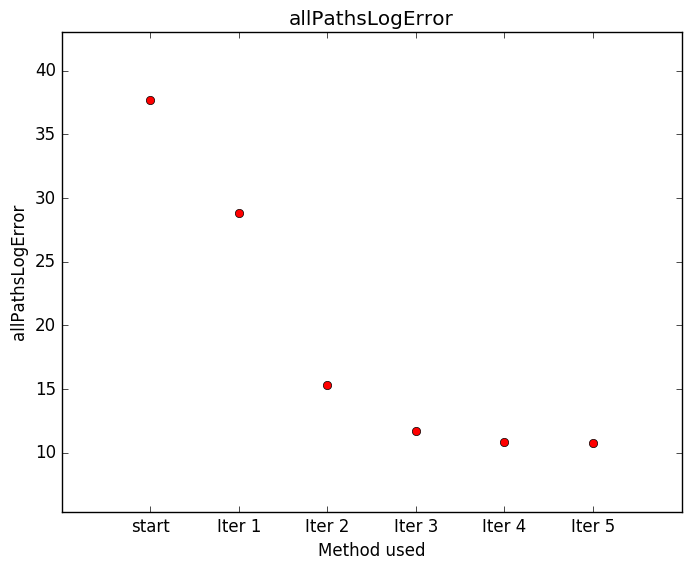

In [9]:
plotStats(stats, "allPathsLogError")